In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [2]:
# Selecting dataset directory

ds_asl_dir = "./asl_dataset"

# Generating a dataset

asl_ds = tf.keras.preprocessing.image_dataset_from_directory(ds_asl_dir)

Found 2515 files belonging to 36 classes.


In [3]:
pd.DataFrame(asl_ds.class_names)

,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [4]:
for image_batch, labels_batch in asl_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [5]:
from PIL import Image
img =  Image.open("./asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
width, height = img.size
print(f"Image sample with width={width} and height={height}.")

Image sample with width=400 and height=400.


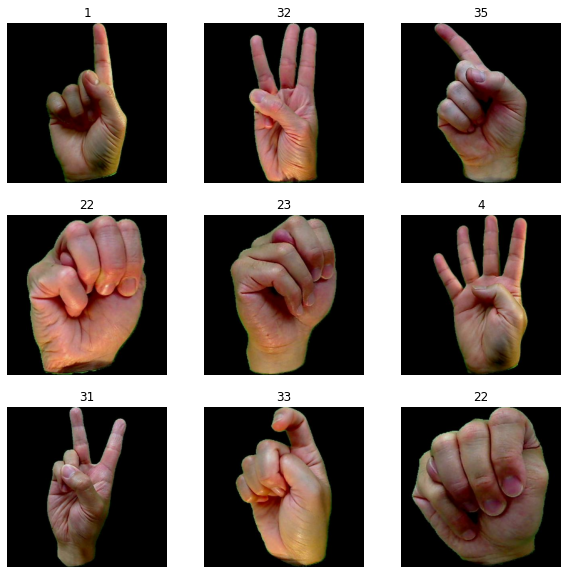

In [6]:
#Displaying image samples

plt.figure(figsize=(10, 10))
for images, labels in asl_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
#Defining parameters for the loader

batch_size = 32
img_height = 64
img_width = 64

#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(ds_asl_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Augmenting the images

from keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, rescale=1/255, zoom_range=0.1, horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

#Setting train/test split

asl_train_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")
asl_test_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, subset="validation")

Deleted 0 images
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [8]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.

from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

#Creating a model

model_dl = keras.Sequential()
model_dl.add(Conv2D(16,(3,3),activation="relu",input_shape=(input_shape)))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))

model_dl.add(Conv2D(32,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))

model_dl.add(Conv2D(64,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))

model_dl.add(Flatten())
model_dl.add(Dense(128,activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(36,activation="softmax"))

In [9]:
#Compiling the neural network

model_dl.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Fitting to the model

from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_accuracy",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

history = model_dl.fit(asl_train_ds, validation_data=asl_test_ds, callbacks=callbacks, epochs=40)

Epoch 1/40
63/63 [==============================] - 6s 85ms/step - loss: 3.4693 - accuracy: 0.0512 - val_loss: 3.1560 - val_accuracy: 0.1431 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 5s 81ms/step - loss: 2.8632 - accuracy: 0.1590 - val_loss: 2.4099 - val_accuracy: 0.2644 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - 5s 82ms/step - loss: 2.2833 - accuracy: 0.2833 - val_loss: 1.9155 - val_accuracy: 0.3956 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 5s 81ms/step - loss: 1.9219 - accuracy: 0.3802 - val_loss: 1.5215 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 5/40
63/63 [==============================] - 5s 81ms/step - loss: 1.7197 - accuracy: 0.4433 - val_loss: 1.3169 - val_accuracy: 0.5586 - lr: 0.0010
Epoch 6/40
63/63 [==============================] - 5s 81ms/step - loss: 1.5292 - accuracy: 0.4891 - val_loss: 1.3078 - val_accuracy: 0.5845 - lr: 0.0010
Epoch 7/40
63/63 [==============================] - 5s 82ms/step - loss: 1.4

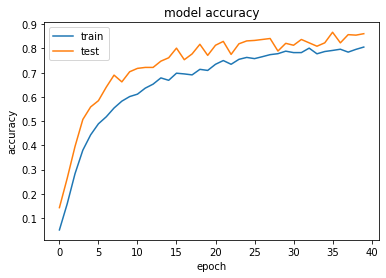

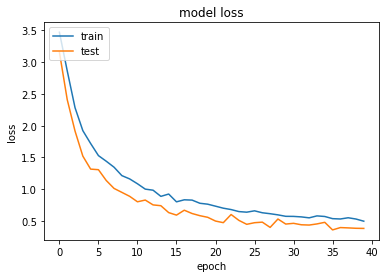

In [10]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Saving the model
model_dl.save('realistic_model.h5')

In [6]:
#We´ll use any image sample from the Kaggle dataset to test it 

from keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np


#Creating a dictionary to map each of the indexes to the corresponding number or letter

dict = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",10:"a",11:"b",12:"c",13:"d",14:"e",15:"f",16:"g",
        17:"h",18:"i",19:"j",20:"k",21:"l",22:"m",23:"n",24:"o",25:"p",26:"q",27:"r",28:"s",29:"t",30:"u",31:"v",32:"w",
        33:"x",34:"y",35:"z"}

# Predicting images
MODEL_PATH = 'realistic_model.h5'
model_dl = load_model(MODEL_PATH)

img = image.load_img("./asl_dataset/n/hand1_n_bot_seg_1_cropped.jpeg", target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
result = model_dl.predict(image)

if result[0][0] == 1:
    prediction = '0'
elif result[0][1] == 1:
    prediction = '1'
elif result[0][2] == 1:
    prediction = '2'
elif result[0][3] == 1:
    prediction = '3'
elif result[0][4] == 1:
    prediction = '4'
elif result[0][5] == 1:
    prediction = '5'
elif result[0][6] == 1:
    prediction = '6'
elif result[0][7] == 1:
    prediction = '7'
elif result[0][8] == 1:
    prediction = '8'
elif result[0][9] == 1:
    prediction = '9'
elif result[0][10] == 1:
    prediction = 'A'
elif result[0][11] == 1:
    prediction = 'B'
elif result[0][12] == 1:
    prediction = 'C'
elif result[0][13] == 1:
    prediction = 'D'
elif result[0][14] == 1:
    prediction = 'E'
elif result[0][15] == 1:
    prediction = 'F'
elif result[0][16] == 1:
    prediction = 'G'
elif result[0][17] == 1:
    prediction = 'H'
elif result[0][18] == 1:
    prediction = 'I'
elif result[0][19] == 1:
    prediction = 'J'
elif result[0][20] == 1:
    prediction = 'K'
elif result[0][21] == 1:
    prediction = 'L'
elif result[0][22] == 1:
    prediction = 'M'
elif result[0][23] == 1:
    prediction = 'N'
elif result[0][24] == 1:
    prediction = 'O'
elif result[0][25] == 1:
    prediction = 'P'
elif result[0][26] == 1:
    prediction = 'Q'
elif result[0][27] == 1:
    prediction = 'R'
elif result[0][28] == 1:
    prediction = 'S'
elif result[0][29] == 1:
    prediction = 'T'
elif result[0][30] == 1:
    prediction = 'U'
elif result[0][31] == 1:
    prediction = 'V'
elif result[0][32] == 1:
    prediction = 'W'
elif result[0][33] == 1:
    prediction = 'X'
elif result[0][34] == 1:
    prediction = 'Y'
elif result[0][35] == 1:
    prediction = 'Z'
    
else:
    prediction = "XXXXXXXX"

print(f'The predicted image corresponds to "{prediction}"')

The predicted image corresponds to "N"
